**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import sympy as sm
from scipy.optimize import Bounds
from scipy.optimize import fsolve
from sympy import pprint
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
C = sm.symbols('C')
G = sm.symbols('G')
nu = sm.symbols('nu')
L = sm.symbols('L')
kappa = sm.symbols('kappa')
w = sm.symbols('w')
tau = sm.symbols('tau')
alpha = sm.symbols('alpha')
w_tilde = sm.symbols('w_tilde')

objective = sm.ln(C**alpha*G**(1-alpha))-nu*L**2/2
constraint = sm.Eq(kappa+w_tilde*L,C)
objective_sub = objective.subs(C,constraint.lhs)

# find the foc of the objective function with respect to L
foc = sm.diff(objective_sub, L)

# set the foc equal to zero and solve for L
optimal_L = sm.solve(sm.Eq(foc,0), L)

# simplify the expression
optimal_L = [sm.simplify(expr) for expr in optimal_L]

# select the second solution
optimal_L_star = optimal_L[1]


# display the optimal labor supply choice with the assigned values
optimal_L_star

(-kappa*nu + sqrt(nu*(4*alpha*w_tilde**2 + kappa**2*nu)))/(2*nu*w_tilde)

Even though it does not look identical, to $\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, it actually is: if you divide both the denominator and the numerator with $\nu$ you will get the exact same results, but sympy is not able to calculate it, even when using its simplify function, and stating that the positive parameters are positive makes it look even less identical. But here is the proof: $\frac{-\kappa\nu+\sqrt{\nu(\kappa^{2}\nu+4\alpha\tilde{w}^2)}}{2\tilde{w}\nu}=\frac{-\kappa+\sqrt{\nu^{-1}(\kappa^{2}\nu+4\alpha\tilde{w}^2)}}{2\tilde{w}}=\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

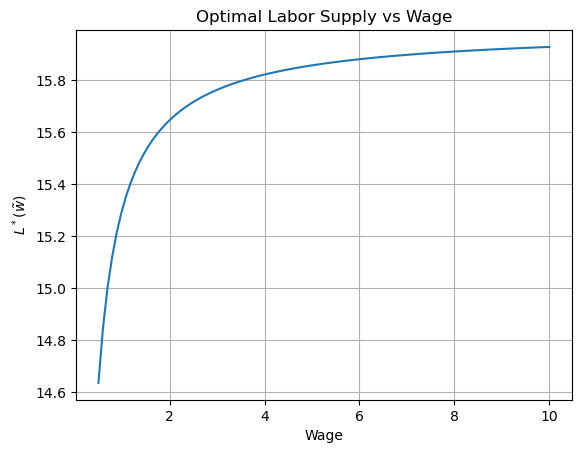

In [3]:
# list for optimal Labour supply
optimal_L_list = []

# w grid
wage_list = np.linspace(0.5,10.0,100)


for wage in wage_list:
    # values
    opt_L = optimal_L_star.copy() #optimal_L_star will be used later, so a copy is made to not change it
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    tau_value = 0.3
    w_tilde_value = (1-tau_value)*wage

    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = opt_L.subs(values) # substitute the symbols for the actual values
    
    optimal_L_list.append(float(opt_L))

# plot the optimal labor supply against the wage
plt.plot(wage_list, optimal_L_list)
plt.xlabel('Wage')
plt.ylabel(r'$L^*(\tilde{w})$')
plt.title('Optimal Labor Supply vs Wage')
plt.grid(True)
plt.show()    

In the figure above we observe how an increasing wage increases the optimal labour supply. The function is concave due to the diminishing marginal utility from consumption in the utility function as well as an increasing marginal disutility from providing labour. The function is stronly increasing when the wage increases from 0.5, but when the wage reaches 2 the slope has decreased significantly, and even when the wage has been increased to 10 it is quite flat.


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


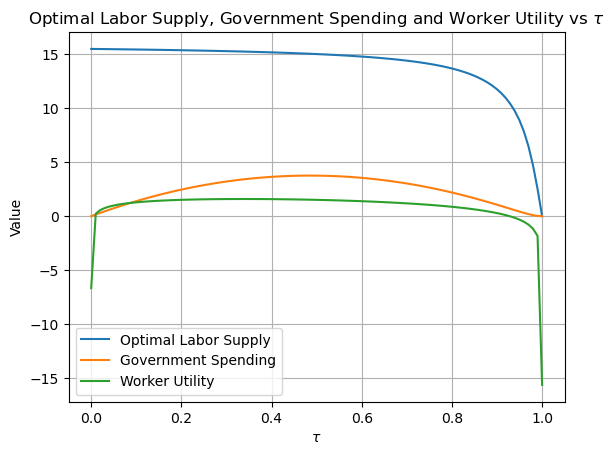

In [4]:
# tau grid
min_tax = 0+1e-8
max_tax = 1-1e-8

tau_list = np.linspace(min_tax,max_tax,100)

# lists
optimal_L_list = []
G_list = []
worker_utility_list = []


for tau in tau_list:
    # values
    opt_L = optimal_L_star.copy() #optimal_L_star will be used later, so a copy is made to not change it
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    tau_value = tau
    wage_value = 1.0
    w_tilde_value = (1-tau_value)*wage_value

    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = optimal_L_star.subs(values) # substitute the symbols for the actual values

    # append lists
    optimal_L_list.append(float(opt_L))
    G = tau_value*wage_value*opt_L*w_tilde_value
    G_list.append(G)
    C = kappa_value + w_tilde_value*opt_L  
    U = np.log(float(C)**alpha_value*float(G)**(1-alpha_value))-nu_value*float(opt_L)**2/2
    worker_utility_list.append(U)

plt.plot(tau_list, optimal_L_list, label='Optimal Labor Supply')
plt.plot(tau_list, G_list, label='Government Spending')
plt.plot(tau_list, worker_utility_list, label='Worker Utility')
plt.xlabel(r'$\tau$')
plt.ylabel('Value')
plt.title(r'Optimal Labor Supply, Government Spending and Worker Utility vs $\tau$')
plt.legend()
plt.grid(True)
plt.show()

In the graph above we observe three graphs:

**1. Optimal Labour Supply:** Here we observe how the tax rates negatively affects the optimal labor supply. This is basically the opposite of the graph "Optimal Labour Supply vs Wage": when the tax rate increases it is equivalent of the wage decreasing, and therefore the optimal labour supply decreases, and when the tax rate approaches 100% working no longer provides any utility.

**2. Government Spending:** Here we observe the famous Laffer curve (since all government earnings are spent). When the tax rate is 0%, the government collect no earnings obviously, but when the tax rate is 100% the government also collect no earnings because the workers stop working meaning there is nothing to tax. In between these extremes we have a polynomial of earnings.

**3. Worker Utility:** Here we observe two kinks: the first one we observe in the very left of the graph, where the worker utility is negative but sharply increases in the tax rate until the utility function becomes none-negative. This is because when the tax-rate is very low (almost 0%), there will be high consumption, but very low government spending, and since the marginal utility of consumption depends on government spending the utility function becomes negative. The second kink we observe is at the very right of the graph where the worker utilty becomes sharply negative and even more negative compared to the first kink. This is because when the tax rate is very high (almost 100%) then the worker stops working making consumption almost zero, and therefore there are no taxes to collect and no government spending. So because both consumption and government spending are very low, it becomes even more negative than the first kink. Between these we observe the "sweet spot" where the tax rate is high enough for government spending to provide a high enough marginal utility of consumption (and vice versa) to make the utility function positive.

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

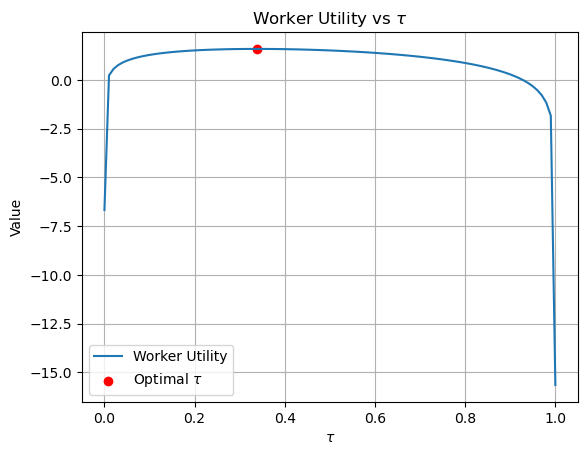

The value of tau that maximizes U is 0.338


In [5]:
def utility(tau_value):
    # values
    opt_L = optimal_L_star.copy() #optimal_L_star will be used later, so a copy is made to not change it
    alpha_value = 0.5
    kappa_value = 1.0
    nu_value = 1/(2*16**2)
    wage_value = 1.0
    w_tilde_value = (1-tau_value)*wage_value
    
    values = {alpha: alpha_value, kappa: kappa_value, nu: nu_value, w_tilde: w_tilde_value}
    opt_L = optimal_L_star.subs(values) # substitute the symbols for the actual values
    
    # append lists
    G = tau_value*wage_value*opt_L*w_tilde_value
    C = kappa_value + w_tilde_value*opt_L  
    U = np.log(float(C)**alpha_value*float(G)**(1-alpha_value))-nu_value*float(opt_L)**2/2
    return -U  # return -U because we want to maximize U and we use a minimizer

# find the value of tau_value that maximizes U
result = minimize_scalar(utility, bounds=(min_tax, max_tax), method='bounded')

optimal_tau_value = result.x
optimal_worker_utility = -utility(optimal_tau_value)


plt.plot(tau_list, worker_utility_list, label='Worker Utility')
plt.scatter(optimal_tau_value, optimal_worker_utility, color='red', label=r'Optimal $\tau$')  # add a red dot at the optimal point
plt.xlabel(r'$\tau$')
plt.ylabel('Value')
plt.title(r'Worker Utility vs $\tau$')
plt.legend()
plt.grid(True)
plt.show()

print(f"The value of tau that maximizes U is {optimal_tau_value:.3f}")

In the graph above the the tax rate that maximizes the worker utility function is plotted, and its is approx. 33.8%.

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [6]:
# set the parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0
tau = round(optimal_tau_value,10) # due to the instability of the worker utility function for set 1, the tax rate can only include 10 decimals


# set 1:
sigma1 = 1.001
rho1 = 1.001
epsilon1 = 1.0

# set 2: 
sigma2 = 1.5
rho2 = 1.5
epsilon2 = 1.0

# utility function (general formulation)
def utility(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    return (((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho) - 1) / (1 - rho) - nu * L ** (1 + epsilon) / (1 + epsilon)

# the objective function we want to minimize 
def objective(L, tau, G, sigma, rho, epsilon):
    return -utility(L, tau, G, sigma, rho, epsilon) # negative utility because we use a minimizer

# optimal labor supply
def optimal_L(tau, G, sigma, rho, epsilon):
    res = minimize(objective, 0.5, args=(tau, G, sigma, rho, epsilon), bounds=[(0, 24)])
    return res.x[0]

# function to find the correct G
def find_G(G, tau, sigma, rho, epsilon):
    L = optimal_L(tau, G, sigma, rho, epsilon)
    return G - tau * w * L

# find G for each parameter set
G1 = fsolve(find_G, 1, args=(tau, sigma1, rho1, epsilon1))
G2 = fsolve(find_G, 1, args=(tau, sigma2, rho2, epsilon2))

error_set1 = find_G(G1, tau, sigma1, rho1, epsilon1)
error_set2 = find_G(G2, tau, sigma2, rho2, epsilon2)

print(f"For Set 1, G = {G1[0]:.3f} solves the equality with an error of {error_set1}")
print(f"For Set 2, G = {G2[0]:.3f} solves the equality with an error of {error_set2}")




For Set 1, G = 5.157 solves the equality with an error of [-4.11904104e-05]
For Set 2, G = 3.528 solves the equality with an error of [5.06018392e-08]


c:\Users\Lenovo\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


For set 1, we see a higher level of government spending than for set 2, meaning that when the parameters approaches the limit value of 1 (approaching 1 from values above 1) the government spendning that solves the equation $G = \tau w L^{\star}((1-\tau)w,G)$ increases.

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [18]:
# set the parameter values
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16 ** 2)
w = 1.0

# utility function (general formulation)
def utility(L, tau, G, sigma, rho, epsilon):
    C = kappa + (1 - tau) * w * L
    return (((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho) - 1) / (1 - rho) - nu * L ** (1 + epsilon) / (1 + epsilon)

# the objective function we want to minimize 
def objective(L, tau, G, sigma, rho, epsilon):
    return -utility(L, tau, G, sigma, rho, epsilon)

# optimal labor supply
def optimal_L(tau, G, sigma, rho, epsilon):
    res = minimize(objective, 0.5, args=(tau, G, sigma, rho, epsilon), bounds=[(0, 24)])
    return res.x[0]

# function to find the correct G
def find_G(G, tau, sigma, rho, epsilon):
    L = optimal_L(tau, G, sigma, rho, epsilon)
    return G - tau * w * L

def opt_tau(tau, sigma, rho, epsilon):
    G = fsolve(find_G, 1, args=(tau, sigma, rho, epsilon))
    L = optimal_L(tau, G, sigma, rho, epsilon)
    U = utility(L, tau, G, sigma, rho, epsilon)
    return -U



# set 1:
sigma1 = 1.001
rho1 = 1.001
epsilon1 = 1.0

# set 2: 
sigma2 = 1.5
rho2 = 1.5
epsilon2 = 1.0


result1 = minimize(opt_tau, optimal_tau_value, args=(sigma1, rho1, epsilon1), bounds=[(min_tax,max_tax)])
result2 = minimize(opt_tau, optimal_tau_value, args=(sigma2, rho2, epsilon2), bounds=[(min_tax,max_tax)])
#from scipy.optimize import differential_evolution
#
## ... (rest of the code)
#
#def optimal_tau_bounds(sigma, rho, epsilon):
#    bounds = [(min_tax, max_tax)]
#    result = differential_evolution(opt_tau, bounds, args=(sigma, rho, epsilon))
#    return result.x
#
#result1 = optimal_tau_bounds(sigma1, rho1, epsilon1)
#result2 = optimal_tau_bounds(sigma2, rho2, epsilon2)
#
opt_tau1 = result1
opt_tau2 = result2

print(f"For set 1, optimal tau = {opt_tau1}")
print(f"For set 2, optimal tau = {opt_tau2}")

#opt_tau1 = result1.x
#opt_tau2 = result2.x
#
#print(f"For set 1, optimal tau = {opt_tau1}")
#print(f"For set 2, optimal tau = {opt_tau2}")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17416\3326800996.py:10: RuntimeWarning: invalid value encountered in power
  return (((alpha * C ** ((sigma - 1) / sigma) + (1 - alpha) * G ** ((sigma - 1) / sigma)) ** (sigma / (sigma - 1))) ** (1 - rho) - 1) / (1 - rho) - nu * L ** (1 + epsilon) / (1 + epsilon)


For set 1, optimal tau =   message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -1.7942284081234607
        x: [ 3.381e-01]
      nit: 1
      jac: [ 8.181e+07]
     nfev: 68
     njev: 34
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
For set 2, optimal tau =   message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: -0.3900614393557679
        x: [ 4.556e-01]
      nit: 7
      jac: [       nan]
     nfev: 134
     njev: 67
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


The optimization fails to converge. We tried to use the code for question 5 and then create a new function with tau as a variable that returns the negative value of the utility while keeping $G = \tau w L^{\star}((1-\tau)w,G)$, and then use a minimizer on this function for tau in order to maximize utility. Sadly, we used a lot of different optimizers, but all of them failed to converge. Set 1 may fail to converge because of the instability that occurs when the values are close to 1.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [8]:
# write your code here
kappa, l, w, eta = sm.symbols('kappa, l, w, eta')
Pi = kappa*l**(1-eta)-w*l
foc = sm.Eq(sm.diff(Pi,l),0)
sol = sm.solve(foc,l)


kappa_value = 1.0
eta_value = 0.5
w_value = 1.0

sol_func = sm.lambdify(args=(kappa,eta,w),expr=sol)
solution = sol_func(kappa_value,eta_value,w_value)

print(f'The calculated solution is: {solution}\nThe manually calculated solution is {((1-eta_value)*kappa_value/w_value)**(1/eta_value)}')
#print(f'{((1-eta_value)*kappa_value/w_value)**(1/eta_value)}')

#values = {kappa: kappa_value, eta: eta_value, w: w_value}
#sol_sub = sol.subs(values)
#sol_sub

The calculated solution is: [0.25]
The manually calculated solution is 0.25


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [9]:
# Baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 10000  # number of simulations

# Initialize arrays
H = 0
kappa_prev = 1
#randomly generated demand shocks for each simulation and each month
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

#iterate over each simulation
for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    # iterate over each month within a simulation
    for t in range(months):
        # Simulate kappa,
        if t == 0: #set set kappa[t] to kappa_prev if its the first month
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])#otherwise, calculate kappa[t] using the log-demand shock process
        
        # calculate the number of hairdressers (l) using the policy
        l[t] = ((1-eta)*kappa[t]/w)**(1/eta)
        
        #  #the adjustment cost is calculated based on the change in the number of employed hairdresser
        if t > 0 and l[t] != l[t-1]:#if the level changes (l[t] != l[t-1]), the adjustment cost is applied
            adjustment_cost = iota
        else:
            adjustment_cost = 0 #otherwise, the adjustment cost is zero

        # calculate the value of the salon for the current month
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# calculate the expected value of the salon
H = H/K
print(f'H = {H:.3f}')

H = 27.717


The higher the value of H, the higher the expected profitability of the salon. In this case, H = 27.634 suggests that, on average, the salon is expected to generate a positive profitover the 10-year planning horizon (120 months).

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
# baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 10000  # number of simulations
Delta = 0.05

# initialize arrays
H = 0
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    for t in range(months):
        # simulate kappa
        if t == 0:
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
        
        # calculate l* using the policy
        l_star = ((1-eta)*kappa[t]/w)**(1/eta)
        
        # if it's the first month (t == 0) or the absolute difference between the previous level and l_star is greater than Delta, the new level is set to l_star
        if t == 0 or np.abs(l[t-1] - l_star) > Delta:
            l[t] = l_star
        else:
            l[t] = l[t-1] # otherwise, the level remains the same as the previous month. 
        
        if t > 0 and l[t] != l[t-1]:
            adjustment_cost = iota
        else:
            adjustment_cost = 0

        # the value of the salon for the current  month and added to the total H
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# calculate the expected value of the salon
H = H/K
print(f'H = {H:.3f}')

H = 28.366


The output H now represents the expected value of the salon when the policy is set to threshold $\Delta = 0.05$,we see that observe that the value of H increases when applying the new policy compared to the baseline policy ($\Delta = 0$). The increase in H indicates that the expected profitability of the salon is higher when the threshold-based adjustment policy is implemented.

This improvement in profitability can be attributed to the fact that the new policy reduces unnecessary adjustments in the hairdresser level for small deviations within the threshold. By avoiding unnecessary adjustments, the salon can avoid the associated adjustment costs ($\iota$) and maintain a more consistent staffing level that is closer to the optimal level given the demand shocks.

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Optimal Delta: 0.081


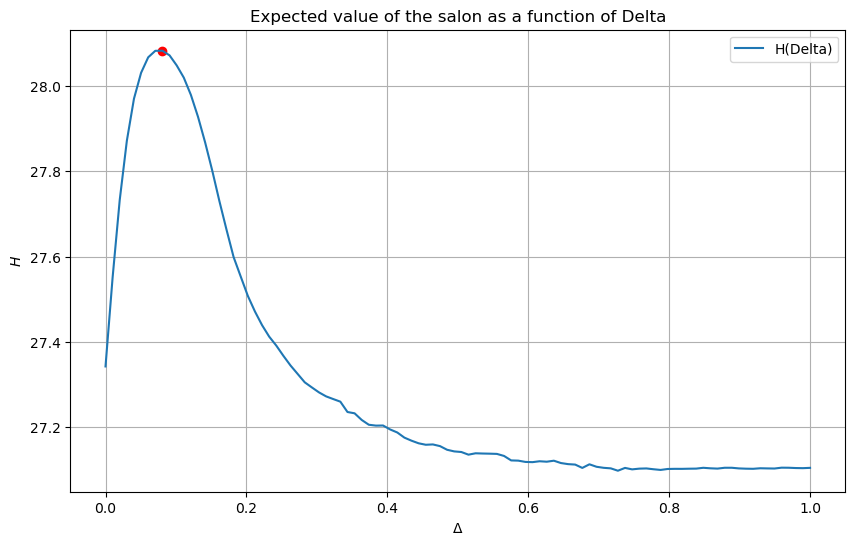

In [11]:
# baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 1000  # number of simulations

# range of Delta values to consider
Delta_values = np.linspace(0, 1, 100)

# initialize arrays
H_values = np.zeros(len(Delta_values))
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

# loop over each Delta value
for i, Delta in enumerate(Delta_values):
    H = 0
    for k in range(K):
        kappa = np.zeros(months)
        l = np.zeros(months)
        for t in range(months):
            # simulate kappa
            if t == 0:
                kappa[t] = kappa_prev
            else:
                kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
            
            # calculate l* using the policy
            l_star = ((1-eta)*kappa[t]/w)**(1/eta)
            
            # apply the new policy
            if t == 0 or np.abs(l[t-1] - l_star) > Delta:
                l[t] = l_star # if it's the first month (t == 0) or the absolute difference between the previous level and l_star is greater than Delta, the new level is set to l_star
            else:
                l[t] = l[t-1] # otherwise, the level remains the same as the previous month
            
            # calculate the adjustment cost
            if t > 0 and l[t] != l[t-1]:
                adjustment_cost = iota
            else:
                adjustment_cost = 0

            # calculate the value of the salon for this month
            H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

    # calculate the expected value of the salon
    H_values[i] = H/K

# find the Delta that gives the highest H
optimal_Delta = Delta_values[np.argmax(H_values)]
optimal_H = np.max(H_values)
print(f'Optimal Delta: {optimal_Delta:.3f}')

# plot H as a function of Delta
plt.figure(figsize=(10, 6))
plt.plot(Delta_values, H_values, label='H(Delta)')
plt.scatter(optimal_Delta, optimal_H, color='red')  # add a red dot at the optimal point
plt.xlabel(r'$\Delta$')
plt.ylabel(r'$H$')
plt.title('Expected value of the salon as a function of Delta')
plt.legend()
plt.grid(True)
plt.show()

We get approx. $\Delta= 0.08$, this suggests that the hair salon should adjust the hairdresser level only if the difference between the current hairdresser level and the desired level (l_star) exceeds 0.08. In other words, if the absolute difference between the previous hairdresser level and the desired level is greater than 0.08, the salon should make an adjustment by changing the hairdresser level.

This is also evident in the graph where we see that when delta takes a value of 0.08,the highest possible value for the profit is attained at about 28.5


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



*Alternative policy* : We try to adjust the hairdresser level based on the trend in the demand shock,  rather than just the current value of the demand shock,so that the salon hires more hairdressers if the demand shock is increasing and gradually reduce  the number of hairdressers if the demand shock is decreasing. The aim is to optimize the hairdresser level by considering the trend in demand, anticipating future changes, and aligning the salon's capacity accordingly.

$$

l[t] = \begin{cases} 
      l^{*} & \text{if } t = 0 \\
      \min(l[t-1] + 0.05, l^{*}) & \text{if } \kappa[t] > \kappa[t-1] \text{ (if $\kappa$ is increasing)} \\
      \max(l[t-1] - 0.05, l^{*}) & \text{otherwise (if $\kappa$ is decreasing)}
   \end{cases}

$$

In [12]:
# baseline parameters
eta = 0.5
w = 1.0
rho = 0.90
iota = 0.01
sigma_epsilon = 0.10
R = (1+0.01)**(1/12)
months = 120
K = 1000  # number of simulations

# initialize arrays
H = 0
kappa_prev = 1
epsilon_vec = np.random.normal(loc=-0.5*sigma_epsilon**2, scale=sigma_epsilon, size=(K, months))

for k in range(K):
    kappa = np.zeros(months)
    l = np.zeros(months)
    for t in range(months):
        # simulate kappa
        if t == 0:
            kappa[t] = kappa_prev
        else:
            kappa[t] = np.exp(rho*np.log(kappa[t-1]) + epsilon_vec[k, t])
        
        # calculate l* using the policy
        l_star = ((1-eta)*kappa[t]/w)**(1/eta)
        
        # apply the new policy: adjust l based on the trend in kappa
        if t == 0:
            l[t] = l_star
        elif kappa[t] > kappa[t-1]:  # if kappa is increasing
            l[t] = min(l[t-1] + 0.05, l_star)  # hire more hairdressers, but not more than l*
        else:  # if kappa is decreasing
            l[t] = max(l[t-1] - 0.05, l_star)  # fire some hairdressers, but not less than l*
        
        # calculate the adjustment cost
        if t > 0 and l[t] != l[t-1]:
            adjustment_cost = iota
        else:
            adjustment_cost = 0

        # calculate the value of the salon for this month
        H += R**(-t)*(kappa[t]*l[t]**(1-eta)-w*l[t]-adjustment_cost)

# calculate the expected value of the salon
H = H/K
print(f'H = {H:.3f}')

H = 27.512


We obtained an expected value of the salon (H) equal to approx. 27.5 for the baseline policy with $\Delta$  = 0, .
For the alternative policy we also get approx. 27.5 - running the code again often yields different results, and sometimes the baseline is higher than the alternative policy suggested here, and sometimes it is the other way around. This new alternative policy is therefore insignificantly more/less profitable than the baseline.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [13]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

The global minimum is at [-5.62908892e-09 -7.36099966e-09] with a function value of 0.0.


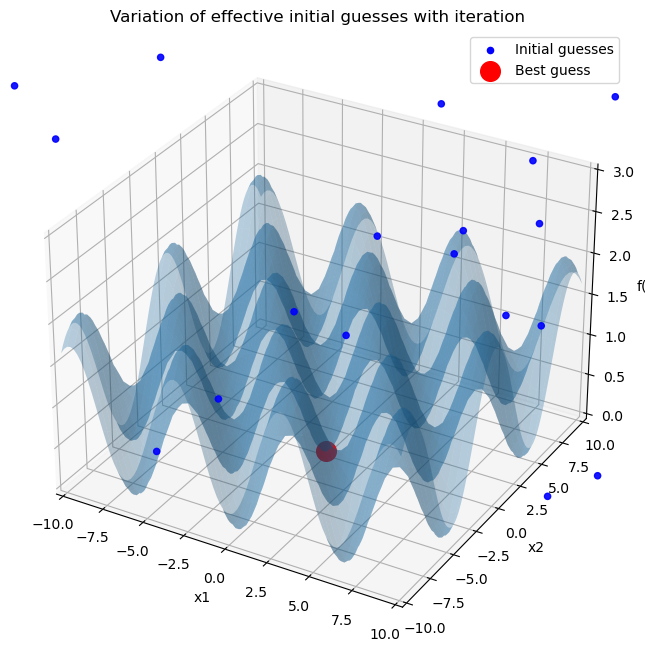

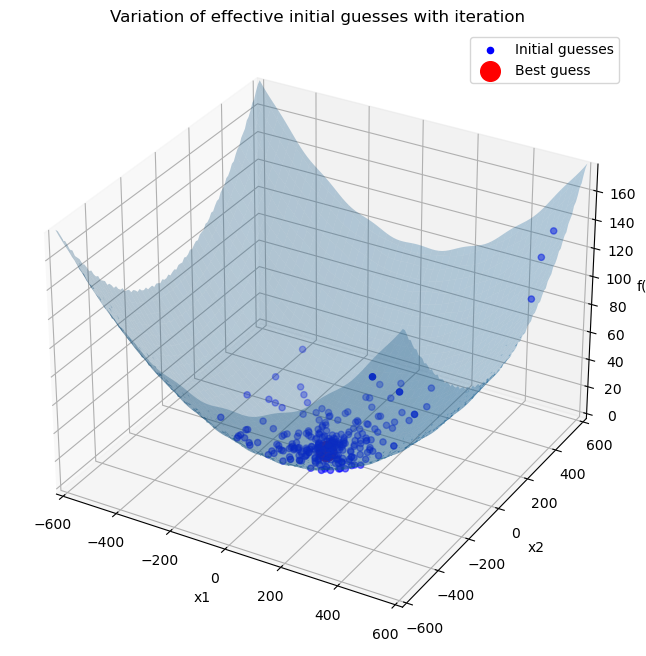

In [14]:
# griewank function
def griewank(x):
    return (x[0]**2 / 4000 + x[1]**2 / 4000) - np.cos(x[0]) * np.cos(x[1] / np.sqrt(2)) + 1

# global optimizer with multi-start
def global_optimizer(K_underline=10, K=1000, bounds=(-600,600), tolerance=1e-8):
    x_star = None
    f_x_star = np.inf
    xk0_values = []
    for k in range(K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)
        if k >= K_underline:
            chi_k = 0.5 * 2 / (1 + np.exp((k - K_underline) / 100))
            x_k = chi_k * x_k + (1 - chi_k) * x_star
        res = minimize(griewank, x_k, method='BFGS', tol=tolerance)
        xk0_values.append(x_k)
        if res.fun < f_x_star:
            x_star = res.x
            f_x_star = res.fun
        if f_x_star < tolerance:
            break
    return x_star, f_x_star, xk0_values

# gunction for generating Griewank values on a grid
def griewank_grid(x1, x2):
    return (x1**2 / 4000 + x2**2 / 4000) - np.cos(x1) * np.cos(x2 / np.sqrt(2)) + 1

# running the optimizer
best_x, best_y, xk0_values = global_optimizer()

# printing the result
print(f'The global minimum is at {best_x} with a function value of {best_y}.')

# illustrating how the effective initial guesses x^{k0} vary with the iteration counter k
xk0_values = np.array(xk0_values)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# generate the grid
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
z = griewank_grid(x, y)

# plotting Griewank function
ax.plot_surface(x, y, z, alpha=0.3)

# create proxy artist for legend
proxy = [Line2D([0], [0], linestyle='none', color='grey', alpha=0.3, marker='o')]
ax.legend(proxy, ['Griewank function'])

# plot initial guesses
ax.scatter(xk0_values[:, 0], xk0_values[:, 1], griewank(xk0_values.T), c='blue', label='Initial guesses')

# plot best guess
ax.scatter(best_x[0], best_x[1], best_y, c='red', s=200, label='Best guess')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

# zoom in
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 3)

plt.title('Variation of effective initial guesses with iteration')
ax.legend()
plt.show()

# second plot zoomed out
# illustrating how the effective initial guesses x^{k0} vary with the iteration counter k
xk0_values = np.array(xk0_values)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# generate grid
x = np.linspace(-600, 600, 100)
y = np.linspace(-600, 600, 100)
x, y = np.meshgrid(x, y)
z = griewank_grid(x, y)

# plot Griewank function
ax.plot_surface(x, y, z, alpha=0.3)

# create proxy artist for legend
proxy = [Line2D([0], [0], linestyle='none', color='grey', alpha=0.3, marker='o')]
ax.legend(proxy, ['Griewank function'])

# plot initial guesses
ax.scatter(xk0_values[:, 0], xk0_values[:, 1], griewank(xk0_values.T), c='blue', label='Initial guesses')

# plot best guess
ax.scatter(best_x[0], best_x[1], best_y, c='red', s=200, label='Best guess')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

# zoom in on specific region
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 600)
ax.set_zlim(0, 175)

plt.title('Variation of effective initial guesses with iteration')
ax.legend()
plt.show()

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

The global minimum is at [-3.1682792e-09 -8.2453990e-11] with a function value of 0.0.


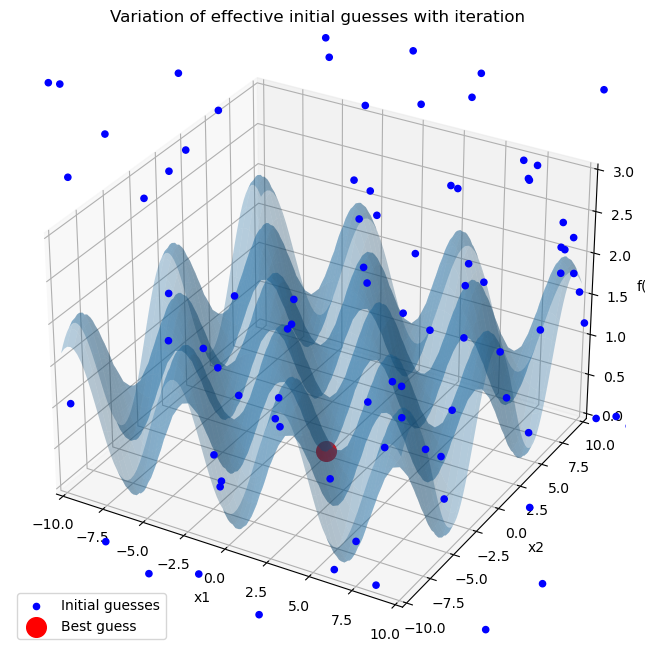

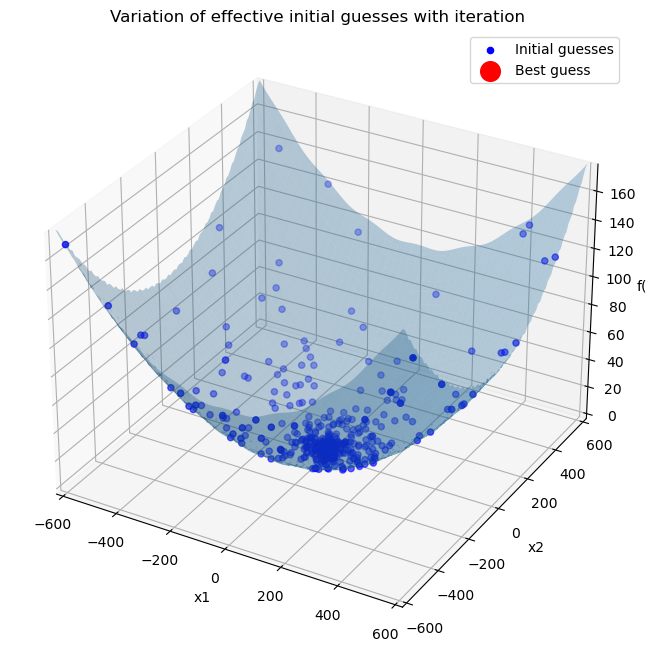

In [15]:
# Griewank function
def griewank(x):
    return (x[0]**2 / 4000 + x[1]**2 / 4000) - np.cos(x[0]) * np.cos(x[1] / np.sqrt(2)) + 1

# global optimizer with multi-start
def global_optimizer(K_underline=100, K=1000, bounds=(-600,600), tolerance=1e-8):
    x_star = None
    f_x_star = np.inf
    xk0_values = []
    for k in range(K):
        x_k = np.random.uniform(bounds[0], bounds[1], size=2)
        if k >= K_underline:
            chi_k = 0.5 * 2 / (1 + np.exp((k - K_underline) / 100))
            x_k = chi_k * x_k + (1 - chi_k) * x_star
        res = minimize(griewank, x_k, method='BFGS', tol=tolerance)
        xk0_values.append(x_k)
        if res.fun < f_x_star:
            x_star = res.x
            f_x_star = res.fun
        if f_x_star < tolerance:
            break
    return x_star, f_x_star, xk0_values

# function for generating Griewank values on a grid
def griewank_grid(x1, x2):
    return (x1**2 / 4000 + x2**2 / 4000) - np.cos(x1) * np.cos(x2 / np.sqrt(2)) + 1

# running the optimizer
best_x, best_y, xk0_values = global_optimizer()

# printing the result
print(f'The global minimum is at {best_x} with a function value of {best_y}.')

# illustrating how the effective initial guesses x^{k0} vary with the iteration counter k
xk0_values = np.array(xk0_values)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# generate grid
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
x, y = np.meshgrid(x, y)
z = griewank_grid(x, y)

# plot Griewank function
ax.plot_surface(x, y, z, alpha=0.3)

# create proxy artist for legend
proxy = [Line2D([0], [0], linestyle='none', color='grey', alpha=0.3, marker='o')]
ax.legend(proxy, ['Griewank function'])

# plot initial guesses
ax.scatter(xk0_values[:, 0], xk0_values[:, 1], griewank(xk0_values.T), c='blue', label='Initial guesses')

# plot best guess
ax.scatter(best_x[0], best_x[1], best_y, c='red', s=200, label='Best guess')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

# zoom in on specific region
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 3)

plt.title('Variation of effective initial guesses with iteration')
ax.legend()
plt.show()

# second plot zoomed out

# illustrating how the effective initial guesses x^{k0} vary with the iteration counter k
xk0_values = np.array(xk0_values)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# generate grid
x = np.linspace(-600, 600, 100)
y = np.linspace(-600, 600, 100)
x, y = np.meshgrid(x, y)
z = griewank_grid(x, y)

# plot Griewank function
ax.plot_surface(x, y, z, alpha=0.3)

# create proxy artist for legend
proxy = [Line2D([0], [0], linestyle='none', color='grey', alpha=0.3, marker='o')]
ax.legend(proxy, ['Griewank function'])

# plot initial guesses
ax.scatter(xk0_values[:, 0], xk0_values[:, 1], griewank(xk0_values.T), c='blue', label='Initial guesses')

# plot best guess
ax.scatter(best_x[0], best_x[1], best_y, c='red', s=200, label='Best guess')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x)')

# zoom in on specific region
ax.set_xlim(-600, 600)
ax.set_ylim(-600, 600)
ax.set_zlim(0, 175)

plt.title('Variation of effective initial guesses with iteration')
ax.legend()
plt.show()

The parameter ${\underline{K}}$ represents the number of "warm-up" iterations, or the number of times that the algorithm generates random initial guesses before it starts using the refined global optimization solver with multi-start that focuses around the best solution found.

If we set ${\underline{K}}$ to a larger value, the algorithm will explore more random points in the search space before it starts to converge around the best point. This could potentially be beneficial if the global minimum is in a region of the search space that is not likely to be selected during the early iterations.

There are trade-offs to this method. Increasing ${\underline{K}}$ can also mean that it takes longer for the algorithm to start its more focused search. If the algorithm is already likely to select good starting points during its random search, then increasing ${\underline{K}}$ might just add extra unnecessary iterations.

From the results we can see that the algorithm finds very similar solutions whether ${\underline{K}}$ is 10 or 100, and they are all very close to the true global minimum (0, 0). This suggests that increasing ${\underline{K}}$ did not significantly improve the accuracy of the solution based on our findings.

In terms of speed, if increasing ${\underline{K}}$ doesn't significantly improve the solution accuracy, it could be argued that it's faster to keep ${\underline{K}}$ lower, because the algorithm starts the refined searching sooner. However, the true measure of speed should be the number of iterations it takes to converge to a solution that is within the desired tolerance. Given that both settings found the global minimum within the total number of iterations, it's not clear from the information provided which setting is faster.

In conclusion, the best value for ${\underline{K}}$ depends on the specific problem, the nature of the objective function, and the desired balance between exploration (trying out many different starting points) and exploitation. If the Griewank function is quite complex and has many local minima, it might be beneficial to set ${\underline{K}}$ to a larger value. But if the function is relatively simple or if computational efficiency is a priority, a smaller ${\underline{K}}$ might be preferable.